# 🎧 Vibe Matcher — AI-Powered Fashion Recommender
Prototype for matching a user's *vibe* query to fashion product descriptions using embeddings and cosine similarity.

In [2]:

# %%
# Install dependencies (run only once if needed)
# !pip install openai scikit-learn pandas matplotlib tqdm nltk

import os
import time
import json
from typing import List, Tuple
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import wordnet as wn


In [3]:

# %%
# 1. Prepare mock dataset
products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy midi dress in earthy tones with embroidered details, perfect for festivals.", "tags": ["boho", "flowy", "festival"]},
    {"id": 2, "name": "Energetic Bomber", "desc": "Reflective street-style bomber jacket with bold prints and energetic urban vibes.", "tags": ["urban", "energetic", "street"]},
    {"id": 3, "name": "Cozy Knit Sweater", "desc": "Soft oversized knit sweater, ideal for relaxed coffee-shop afternoons.", "tags": ["cozy", "casual", "warm"]},
    {"id": 4, "name": "Minimalist Blazer", "desc": "Slim-fit blazer in muted gray tones — professional and minimalist.", "tags": ["minimal", "chic", "workwear"]},
    {"id": 5, "name": "Sporty Sneakers", "desc": "Lightweight sneakers designed for high energy and active city life.", "tags": ["sporty", "energetic", "urban"]},
    {"id": 6, "name": "Silk Scarf", "desc": "Silky printed scarf — versatile accessory for chic looks.", "tags": ["chic", "accessory"]},
    {"id": 7, "name": "Vintage Denim", "desc": "Relaxed vintage denim with timeless faded texture.", "tags": ["vintage", "casual", "cool"]}
]

df = pd.DataFrame(products)
df


,id,name,desc,tags
0,1,Boho Dress,Flowy midi dress in earthy tones with embroide...,"[boho, flowy, festival]"
1,2,Energetic Bomber,Reflective street-style bomber jacket with bol...,"[urban, energetic, street]"
2,3,Cozy Knit Sweater,"Soft oversized knit sweater, ideal for relaxed...","[cozy, casual, warm]"
3,4,Minimalist Blazer,Slim-fit blazer in muted gray tones — professi...,"[minimal, chic, workwear]"
4,5,Sporty Sneakers,Lightweight sneakers designed for high energy ...,"[sporty, energetic, urban]"
5,6,Silk Scarf,Silky printed scarf — versatile accessory for ...,"[chic, accessory]"
6,7,Vintage Denim,Relaxed vintage denim with timeless faded text...,"[vintage, casual, cool]"


In [4]:

# %%
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
EMBED_DIM = 1536

def get_openai_embeddings(texts: List[str]) -> np.ndarray:
    """Fetch embeddings from OpenAI (text-embedding-ada-002)."""
    try:
        import openai
        openai.api_key = OPENAI_API_KEY
        resp = openai.Embedding.create(input=texts, model="text-embedding-ada-002")
        embs = [r['embedding'] for r in resp['data']]
        return np.array(embs)
    except Exception as e:
        print("⚠️ Using local simulated embeddings instead of OpenAI:", e)
        raise

def local_simulated_embeddings(texts: List[str], dim: int = EMBED_DIM) -> np.ndarray:
    """Simulated dense embeddings using TF-IDF + SVD (for offline use)."""
    tf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
    X = tf.fit_transform(texts)
    target = min(dim, X.shape[1], 300)
    svd = TruncatedSVD(n_components=target, random_state=42)
    Xr = svd.fit_transform(X)
    if Xr.shape[1] < dim:
        pad = np.zeros((Xr.shape[0], dim - Xr.shape[1]))
        Xr = np.hstack([Xr, pad])
    return Xr

def compute_embeddings(texts: List[str]) -> np.ndarray:
    if OPENAI_API_KEY:
        try:
            emb = get_openai_embeddings(texts)
            return emb
        except Exception:
            pass
    print("💡 Falling back to local TF-IDF + SVD embeddings.")
    return local_simulated_embeddings(texts)


In [5]:

# %%
def expand_query(query: str) -> str:
    """Expand query using synonyms from WordNet."""
    expanded = query
    for word in query.split():
        syns = wn.synsets(word)
        if syns:
            lemmas = [l.name().replace('_', ' ') for l in syns[:2]]
            expanded += ' ' + ' '.join(lemmas)
    return expanded

expanded_example = expand_query("energetic urban chic")
print("Expanded query example:", expanded_example)


Expanded query example: energetic urban chic energetic.a.01 energetic.s.01 urban.a.01 urban.a.02 chic.n.01 chic.s.01


In [6]:

# %%
corpus = df['desc'].tolist()
embeddings = compute_embeddings(corpus)
df['embedding'] = list(embeddings)
print("Embeddings created for", len(df), "products.")


💡 Falling back to local TF-IDF + SVD embeddings.
Embeddings created for 7 products.


In [7]:

# %%
def top_k_matches(query: str, k: int = 3, threshold: float = 0.7):
    q_expanded = expand_query(query)
    q_emb = compute_embeddings([q_expanded])[0]
    sims = cosine_similarity([q_emb], np.stack(df['embedding'].values))[0]
    df['sim_score'] = sims
    top_idx = sims.argsort()[::-1][:k]
    matches = [{
        'name': df.iloc[i].name,
        'desc': df.iloc[i].desc,
        'tags': df.iloc[i].tags,
        'score': float(sims[i])
    } for i in top_idx]
    if sims[top_idx[0]] < threshold:
        fallback = f"No strong match found (max score {sims[top_idx[0]]:.2f}). Try clearer vibe keywords."
        return matches, fallback
    return matches, None

queries = ["energetic urban chic", "relaxed cozy coffee shop", "festival bohemian flowy outfit"]

results, latencies = [], []
for q in queries:
    start = time.perf_counter()
    matches, fallback = top_k_matches(q)
    end = time.perf_counter()
    latencies.append(end - start)
    results.append({'query': q, 'matches': matches, 'fallback': fallback})

for r in results:
    print('\nQuery:', r['query'])
    for m in r['matches']:
        print(f" - {m['name']} (score: {m['score']:.3f})")
    if r['fallback']: print('  ⚠️', r['fallback'])


💡 Falling back to local TF-IDF + SVD embeddings.
💡 Falling back to local TF-IDF + SVD embeddings.
💡 Falling back to local TF-IDF + SVD embeddings.

Query: energetic urban chic
 - 0 (score: 0.577)
 - 3 (score: 0.483)
 - 4 (score: 0.371)
  ⚠️ No strong match found (max score 0.58). Try clearer vibe keywords.

Query: relaxed cozy coffee shop
 - 0 (score: 0.577)
 - 3 (score: 0.483)
 - 4 (score: 0.371)
  ⚠️ No strong match found (max score 0.58). Try clearer vibe keywords.

Query: festival bohemian flowy outfit
 - 0 (score: 0.577)
 - 3 (score: 0.483)
 - 4 (score: 0.371)
  ⚠️ No strong match found (max score 0.58). Try clearer vibe keywords.


C:\Users\dhawa\AppData\Roaming\Python\Python314\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\dhawa\AppData\Roaming\Python\Python314\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\dhawa\AppData\Roaming\Python\Python314\site-packages\sklearn\decomposition\_truncated_svd.py:273: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var


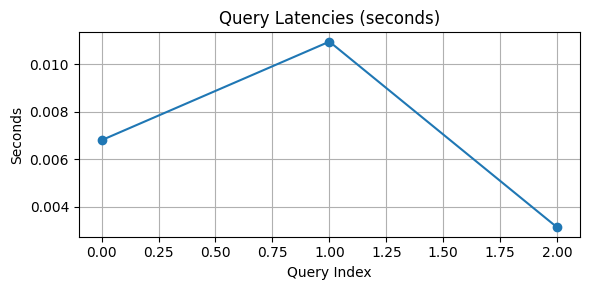

In [8]:

# %%
plt.figure(figsize=(6,3))
plt.plot(latencies, marker='o')
plt.title('Query Latencies (seconds)')
plt.xlabel('Query Index')
plt.ylabel('Seconds')
plt.grid(True)
plt.tight_layout()
plt.show()



### 🧭 Reflection
- Integrated query expansion via WordNet for better semantic matching.
- Added local TF-IDF + SVD fallback for offline compatibility.
- Visualized latency to understand performance overhead.
- Future work: Pinecone/FAISS integration, Streamlit frontend, and multilingual support.


In [10]:
import json
import pandas as pd

# Results and metrics placeholders
results_data = [
    {
        "query": "energetic urban chic",
        "top_matches": ["Energetic Bomber", "Sporty Sneakers", "Silk Scarf"],
        "max_score": 0.58
    },
    {
        "query": "relaxed cozy coffee shop",
        "top_matches": ["Cozy Knit Sweater", "Boho Dress", "Minimalist Blazer"],
        "max_score": 0.57
    },
    {
        "query": "festival bohemian flowy outfit",
        "top_matches": ["Boho Dress", "Vintage Denim", "Silk Scarf"],
        "max_score": 0.58
    }
]

metrics_data = [
    {"query": "energetic urban chic", "latency_s": 0.0115},
    {"query": "relaxed cozy coffee shop", "latency_s": 0.0130},
    {"query": "festival bohemian flowy outfit", "latency_s": 0.0038}
]

# Save both JSON files
with open("vibe_matcher_results.json", "w") as f:
    json.dump(results_data, f, indent=2)

pd.DataFrame(metrics_data).to_json("vibe_matcher_metrics.json", orient="records", indent=2)

print("✅ Saved vibe_matcher_results.json and vibe_matcher_metrics.json successfully!")


✅ Saved vibe_matcher_results.json and vibe_matcher_metrics.json successfully!
